In [ ]:
# Google Colab
# Install huggingface pytorch version transformers packages
from IPython.display import clear_output
!pip install transformers
clear_output()

In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks

# Huggingface Pytorch Transformers
import transformers
from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation, get_linear_schedule_with_warmup

# albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# OpenCV
import cv2
# from google.colab.patches import cv2_imshow

# Others
import os
import math
from PIL import Image
from tqdm import tqdm

from collections import defaultdict
import random
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# import os
# from google.colab import drive
# # Google Colab with Personal Google Drive
# drive.mount('/content/drive')
# # Change to project folder
# path = r"/content/drive/MyDrive/COMP6200 Master Project"
# os.chdir(path)
# os.path.abspath(os.curdir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/COMP6200 Master Project'

In [ ]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torch.cuda.is_available())

if torch.cuda.is_available():
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))

1.12.1+cu113
False


# Iris Segmentation Demonstration

In [ ]:
image_url = "./C1_S1_I1_image.tiff"
mask_url = "./C1_S1_I1_mask.tiff"
image = cv2.imread(image_url, cv2.IMREAD_UNCHANGED)
mask = cv2.imread(mask_url, cv2.IMREAD_UNCHANGED)
print(image.shape)
print(mask.shape)

(300, 400, 3)
(300, 400)


In [ ]:
resize_transform = A.Compose(
    [
     A.Resize(height=640, width=640, interpolation=cv2.INTER_LINEAR),
     ToTensorV2()
    ]
)

image_resize = resize_transform(image=image)

image_aug = torch.zeros((3, 640, 640))

for i in range(3):
  image_aug[i] = image_resize['image'][0]

In [ ]:
image_aug = torch.unsqueeze(image_aug, dim=0)
print(image_aug.shape)

torch.Size([1, 3, 640, 640])


In [ ]:
params = {
    'model': "apple/deeplabv3-mobilevit-small",
    'device': "cuda:0" if torch.cuda.is_available() else "cpu",
    'batch_size': 16,
    'num_workers': 0,
    'lr': 0.0001,
    'epochs': 1,
    'num_labels': 1,
    'label2id':{
      'iris': 1,
    },
    'id2label':{
      '1': 'iris',
    },
}

In [ ]:
IrisViT_seg_model = MobileViTForSemanticSegmentation.from_pretrained(params['model'])
IrisViT_seg_model.segmentation_head.classifier.convolution = nn.Sequential(nn.Conv2d(256, 1, kernel_size=(1,1), stride=(1,1)),
                                                                           nn.UpsamplingNearest2d((640, 640)))

# Change model to fit our task
IrisViT_seg_model.config.id2label = params['id2label']
IrisViT_seg_model.config.label2id = params['label2id']
IrisViT_seg_model.config.num_labels = params['num_labels']

model_save_path = r"./models/segmentation/all_datasets/IrisViT_seg_model_small.pth"
IrisViT_seg_model.load_state_dict(torch.load(model_save_path, map_location=params['device']))

# # To GPU
# IrisViT_seg_model.to(params['device'])

<All keys matched successfully>

In [ ]:
# inputs = feature_extractor(images=image, return_tensors="pt")
# print(inputs['pixel_values'].shape)
outputs = IrisViT_seg_model(image_aug)
print(outputs.logits.shape)

torch.Size([1, 1, 640, 640])


In [ ]:
logits = outputs.logits
probabilities = torch.sigmoid(logits.squeeze(1))
predicted_masks = (probabilities >= 0.5).float() * 1
predicted_masks_np = predicted_masks.cpu().numpy()[0]
print(predicted_masks_np.shape)

(640, 640)


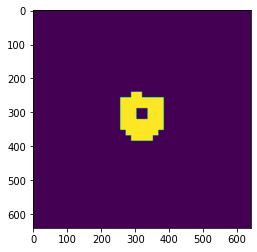

In [ ]:
plt.imshow(predicted_masks_np)

In [ ]:
mask_resize_transform = A.Compose(
    [
     A.Resize(height=300, width=400, interpolation=cv2.INTER_NEAREST),
    ]
)

resize_back = mask_resize_transform(image=predicted_masks_np)
mask_resize_transform_resized = resize_back['image']

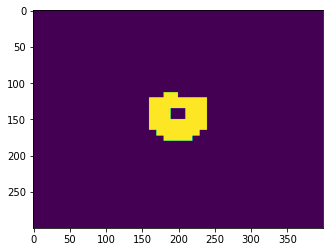

In [ ]:
plt.imshow(mask_resize_transform_resized)

In [ ]:
import torchvision
image_RGB = Image.open(image_url)
mask = Image.open(mask_url)
# Convert the image to PyTorch tensor
image_resize = torchvision.transforms.Resize((300,400))(image_RGB)
image_tensor = torchvision.transforms.functional.pil_to_tensor(image_resize)
mask_resize = torchvision.transforms.Resize((300,400))(mask)
mask_tensor = torchvision.transforms.functional.pil_to_tensor(mask_resize)
print(image_tensor.shape)
print(mask_tensor.shape)

torch.Size([3, 300, 400])
torch.Size([1, 300, 400])


In [ ]:
pred_mask_tensor = T.ToTensor()(mask_resize_transform_resized)
pred_mask_tensor = pred_mask_tensor.type(torch.uint8)
pred_mask_tensor.shape

torch.Size([1, 300, 400])

In [ ]:
def get_true_false_positive_negative(pred_mask, true_mask):

    h,w = true_mask.size()
    num_pixel = h*w

    pred_mask = pred_mask>0
    true_mask = true_mask>0

    true_positive = (true_mask & pred_mask).sum()
    false_positive = (~true_mask & pred_mask).sum()
    true_negative = (~(true_mask | pred_mask)).sum()
    false_negative = (true_mask & (~pred_mask)).sum()

    return {'true_positive': true_positive/num_pixel,
            'false_positive': false_positive/num_pixel,
            'true_negative': true_negative/num_pixel,        
            'false_negative': false_negative/num_pixel}

# [0,1] The lower the better 0 is the best, 1 is the worst
def get_E1(batch_size, pred_masks, true_masks):

    e1_sum = 0
    for i in range(batch_size):
      tpfn = get_true_false_positive_negative(pred_masks[i], true_masks[i])
      fp, fn = tpfn['false_positive'], tpfn['false_negative']
      e1_sum += (fp+fn)

    return e1_sum/batch_size*100

# [0,1] The lower the better, 0 is the best, 1 is the worst
def get_E2(batch_size, pred_masks, true_masks):

    e2_sum = 0
    for i in range(batch_size):
        tpfn = get_true_false_positive_negative(pred_masks[i], true_masks[i])
        fp, fn = tpfn['false_positive'], tpfn['false_negative']
        e2_sum += 0.5*(fp+fn)

    return e2_sum/batch_size*100

# [0,1] 0 is the worst, 1 is the best The higher the better
def get_mIoU(batch_size, pred_masks, true_masks):
    miou_sum = 0
    for i in range(batch_size):
        tfpn = get_true_false_positive_negative(pred_masks[i], true_masks[i])
        tp, fp, fn = tfpn['true_positive'], tfpn['false_positive'], tfpn['false_negative']
        if tp+fn+fp == 0:
            miou=1
        else:
            miou=tp/(tp+fn+fp)
        miou_sum += miou

    return miou_sum/batch_size

def evaluate_segmentation(pred_masks, true_masks):

    batch_size = true_masks.size()[0]

    e1 = get_E1(batch_size,  pred_masks, true_masks)
    e2 = get_E2(batch_size,  pred_masks, true_masks)
    miou = get_mIoU(batch_size, pred_masks, true_masks)

    return {'E1': e1, 
            'E2': e2,
            'mIoU': miou,}

In [ ]:
evaluate_segmentation(pred_mask_tensor, mask_tensor)

{'E1': tensor(0.8950), 'E2': tensor(0.4475), 'mIoU': tensor(0.7614)}

In [ ]:
mask_tensor = ~mask_tensor.type(torch.bool)
pred_mask_tensor = ~pred_mask_tensor.type(torch.bool)

# print(mask_tensor)
# print(pred_mask_tensor)

In [ ]:
original_iris_only = draw_segmentation_masks(image_tensor, mask_tensor, alpha=1, colors=(0,0,0))
pred_iris_only = draw_segmentation_masks(image_tensor, pred_mask_tensor, alpha=1, colors=(0,0,0))

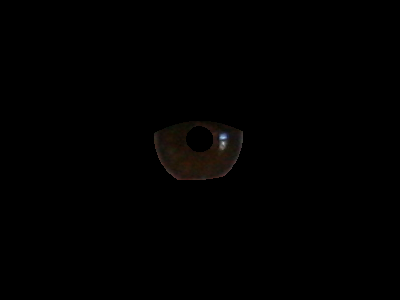

In [ ]:
display(T.ToPILImage()(original_iris_only))

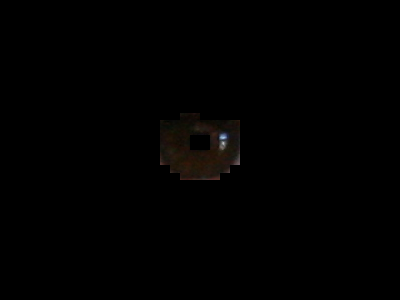

In [ ]:
display(T.ToPILImage()(pred_iris_only))

In [ ]:
original_iris_only_np = np.array(T.ToPILImage()(original_iris_only))
pred_iris_only_np = np.array(T.ToPILImage()(pred_iris_only))

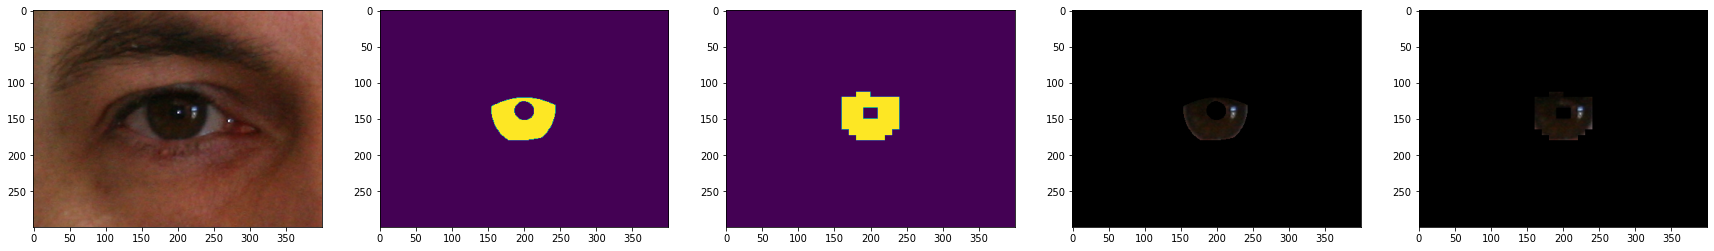

In [ ]:
fig, ax =  plt.subplots(nrows=1, ncols=5, figsize=(30,30))
# ax[0].axis('off')
# ax[1].axis('off')
image_changed_channel = image[:, :, ::-1]
ax[0].imshow(image_changed_channel)
ax[1].imshow(mask)
ax[2].imshow(mask_resize_transform_resized)
ax[3].imshow(original_iris_only_np)
ax[4].imshow(pred_iris_only_np)